In [1]:
!pip install transformers
!pip install datasets


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import nltk
import re
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from collections import Counter, defaultdict

from datasets import Dataset
import torch
import transformers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,precision_score,accuracy_score,f1_score

from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments, DistilBertTokenizerFast,DistilBertForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import torch

device = torch.device("cpu")  # Force CPU since ROCm is not supported on Windows
print(device)

cpu


In [4]:
url='https://raw.githubusercontent.com/achrafbalij/Sentiment-Analysis-on-Financial-News/main/all-data.csv'
data=pd.read_csv(url, encoding="cp1252",header=None)
data.columns = ['sentiment', 'text']

In [5]:
data

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


<Axes: xlabel='sentiment', ylabel='count'>

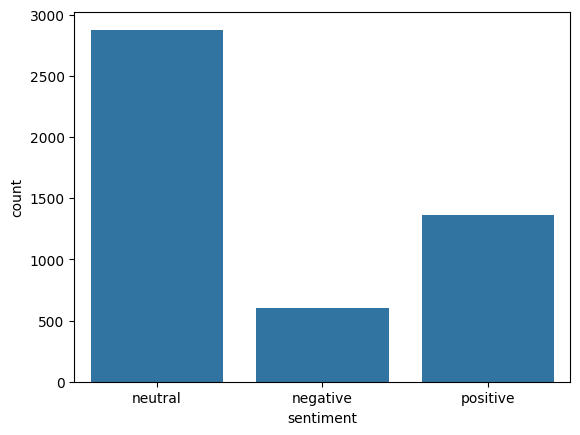

In [6]:
data.shape
data.isna().sum()
data.sentiment.value_counts()/data.shape[0]
sns.countplot(x="sentiment", data=data)

In [7]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def cleaning_data(text):
  text = str(text).lower()
  text = text.replace('{html}', "")
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', text)
  rem_url=re.sub(r'http\S+', '',cleantext)
  rem_num = re.sub('[0-9]+', '', rem_url)
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(rem_num)  
  filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
  stem_words=[stemmer.stem(w) for w in filtered_words]
  lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
  return " ".join(filtered_words)
data['text']=data['text'].map(lambda s:cleaning_data(s)) 

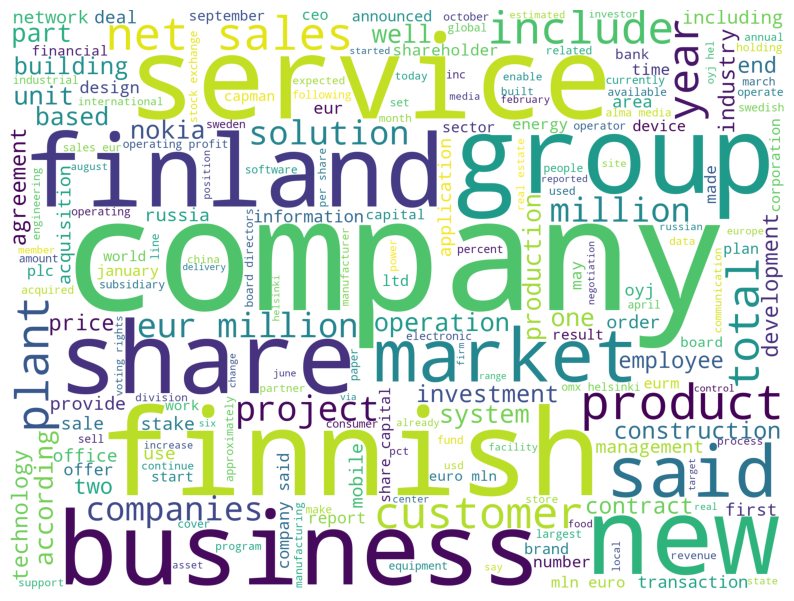

In [8]:
def plot_wordcloud(data):
  words = ' '.join(data['text'])
  no_urls_no_tags = " ".join([word for word in words.split()])

  wordcloud = WordCloud(stopwords=STOPWORDS,
                        background_color='white',
                        width=2000,
                        height=1500
                      ).generate(no_urls_no_tags)

  plt.figure(1,figsize=(10, 10))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

plot_wordcloud(data[data['sentiment']=='neutral'])

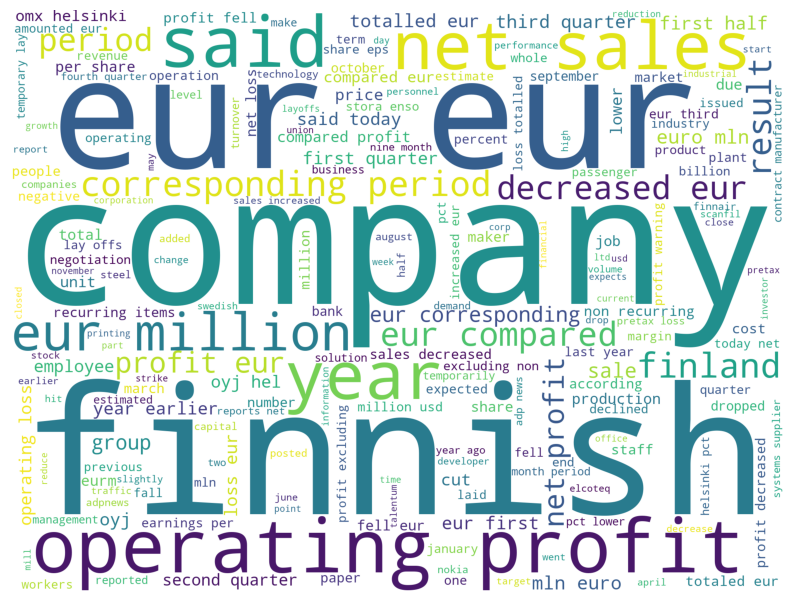

In [9]:
plot_wordcloud(data[data['sentiment']=='negative'])

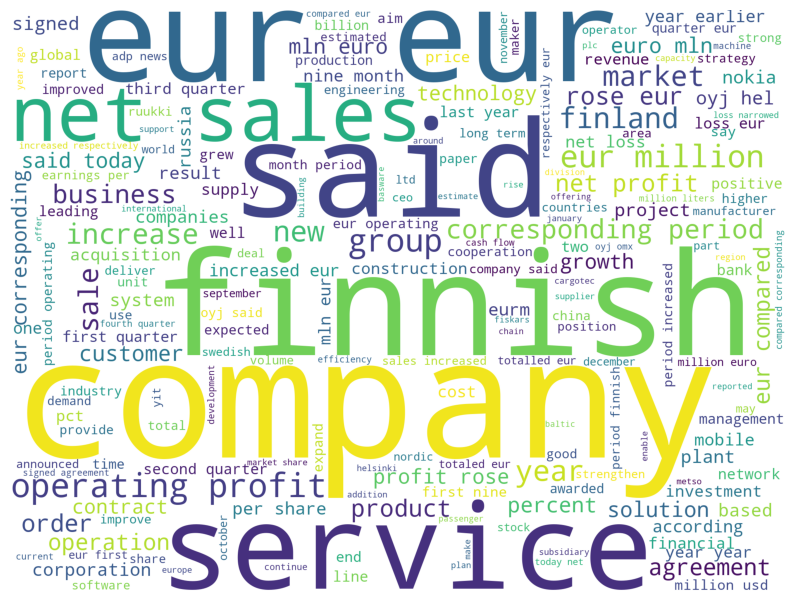

In [10]:
plot_wordcloud(data[data['sentiment']=='positive'])

In [11]:
def ngrams(input, n):
    """ INPUT : Sentence and number of n-grams
  OUTPUT N-Grams
  An n-gram is a contiguous sequence of n items from a given sample of text or speech.
  """
    output = []
    for i in range(len(input)-n+1):
        output.append('_'.join(input[i:i+n]))
    return output

In [12]:
import nltk
nltk.download('punkt_tab')

# Ensure the language is explicitly specified in the word_tokenize function
tags = ['neutral', 'negative', 'positive']

df = data[data.sentiment.isin(tags)]

df['Tokens'] = df.apply(lambda row: nltk.word_tokenize(row['text'].strip()), axis=1)
df['bi_Grams'] = df.apply(lambda row: ngrams(row['Tokens'], 2), axis=1)
df['tri_Grams'] = df.apply(lambda row: ngrams(row['Tokens'], 3), axis=1)

print(len(df),'samples from',len(tags),'classes')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


4846 samples from 3 classes


In [13]:
c_unique = Counter()
for ind in df.index:
    c_unique.update(Counter(set(df.loc[ind]['Tokens'])))

print('First 20 common words:\n')
for word in c_unique.most_common(20):
    print(word[0],'-->', 'appeared in',word[1],'documents out of {} documents i.e.'.format(len(df)),np.round(100*word[1]/len(df),2),'%')

First 20 common words:

company --> appeared in 801 documents out of 4846 documents i.e. 16.53 %
eur --> appeared in 801 documents out of 4846 documents i.e. 16.53 %
said --> appeared in 544 documents out of 4846 documents i.e. 11.23 %
finnish --> appeared in 512 documents out of 4846 documents i.e. 10.57 %
sales --> appeared in 428 documents out of 4846 documents i.e. 8.83 %
profit --> appeared in 406 documents out of 4846 documents i.e. 8.38 %
net --> appeared in 384 documents out of 4846 documents i.e. 7.92 %
year --> appeared in 341 documents out of 4846 documents i.e. 7.04 %
finland --> appeared in 331 documents out of 4846 documents i.e. 6.83 %
million --> appeared in 311 documents out of 4846 documents i.e. 6.42 %
group --> appeared in 305 documents out of 4846 documents i.e. 6.29 %
operating --> appeared in 294 documents out of 4846 documents i.e. 6.07 %
new --> appeared in 261 documents out of 4846 documents i.e. 5.39 %
business --> appeared in 251 documents out of 4846 docume

In [14]:
sent = data.sentiment.unique()
index = [i for i in range(len(sent.tolist()))]
label = dict(zip(sent, index))

sent = list(sent)
data['label'] = data.sentiment.replace(label)
data.head()

,sentiment,text,label
0,neutral,according gran company plans move production r...,0
1,neutral,technopolis plans develop stages area less squ...,0
2,negative,international electronic industry company elco...,1
3,positive,new production plant company would increase ca...,2
4,positive,according company updated strategy years baswa...,2


In [15]:
df_temp, df_test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['sentiment'])
df_train, df_val = train_test_split(df_temp, test_size=0.1, random_state=42, stratify=df_temp['sentiment'])
print("size of training set : " + str(df_train.shape[0]))
print("size of validation set : " + str(df_val.shape[0]))
print("size of test set : " + str(df_test.shape[0]))

size of training set : 3488
size of validation set : 388
size of test set : 970


<Axes: xlabel='sentiment', ylabel='count'>

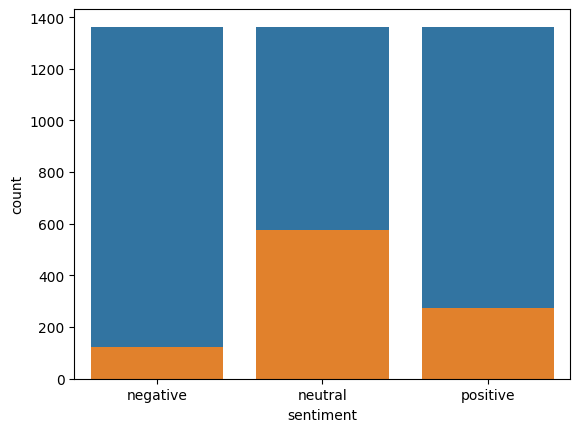

In [16]:
from sklearn.utils import resample

sentiment = data.sentiment.unique()
max = 2
target_majority = data[data.sentiment==sentiment[max]]


for cl in range(3):
    train_minority = df_train[df_train.sentiment==sentiment[cl]]
    train_minority_upsampled = resample(train_minority, replace=True, n_samples=len(target_majority), random_state=33)
    if cl == 0:
        train_upsampled = pd.concat([train_minority_upsampled, target_majority])
        #train_upsampled = pd.concat([train_upsampled, ])
    if cl>0 and cl!=max:
        train_upsampled = pd.concat([train_minority_upsampled, train_upsampled])

train_upsampled['sentiment'].value_counts()
sns.countplot(x="sentiment", data=train_upsampled)
sns.countplot(x="sentiment", data=df_test)

In [17]:
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
dataset_train = Dataset.from_pandas(train_upsampled)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/4089 [00:00<?, ? examples/s]

Map:   0%|          | 0/388 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

In [19]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : accuracy_score(predictions, labels)}

In [20]:
args = TrainingArguments(
    output_dir='temp/',
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    num_train_epochs=3,           # Reduce epochs for efficiency
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,  
    warmup_ratio=0.1,             # Use ratio instead of fixed steps
    weight_decay=0.01,            
    logging_dir='./logs',         
    load_best_model_at_end=True,  # Automatically keeps best model
    save_strategy="epoch",        # Save best model per epoch
    metric_for_best_model="accuracy", # Track accuracy
    greater_is_better=True,
    save_total_limit=2,           # Keep only best models
    fp16=True,                    # Enable mixed precision for faster training
    report_to="none"               # Disable logging to external services
)
trainer = Trainer(
        model=model,                         
        args=args,                  
        train_dataset=dataset_train,         
        eval_dataset=dataset_val,           
        compute_metrics=compute_metrics
)

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.522381,0.788660
2,0.427200,0.460277,0.842784
3,0.427200,0.805686,0.809278


TrainOutput(global_step=768, training_loss=0.31406664351622265, metrics={'train_runtime': 6512.2997, 'train_samples_per_second': 1.884, 'train_steps_per_second': 0.118, 'total_flos': 806903073817344.0, 'train_loss': 0.31406664351622265, 'epoch': 3.0})

In [21]:
model.eval()
trainer.predict(dataset_test).metrics

{'test_loss': 0.5243562459945679,
 'test_accuracy': 0.8381443298969072,
 'test_runtime': 134.9692,
 'test_samples_per_second': 7.187,
 'test_steps_per_second': 0.119}

In [25]:
labels = {v: k for k, v in label.items()}
preds = trainer.predict(dataset_test)
probs = torch.from_numpy(preds[0]).softmax(1)
predictions = probs.numpy()# convert tensors to numpy array

new_df = pd.DataFrame(predictions,columns=data.sentiment.unique())

results = np.argmax(predictions,axis=1)

df_test_finbert = df_test.copy()

df_test_finbert['Sentiment_pred'] = results
df_test_finbert['Sentiment_pred'] = df_test_finbert['Sentiment_pred'].map(labels)

df_test_finbert['pred_label'] = results

df_test_finbert.head()

,sentiment,text,label,Sentiment_pred,pred_label
2108,neutral,following payment made april company total eur...,0,neutral,0
4276,neutral,share subscription period options commence sep...,0,neutral,0
478,neutral,aspocomp intends set plant manufacture printed...,0,neutral,0
810,positive,finnish rautaruukki awarded contract supply in...,2,positive,2
4648,negative,finnish bank _land reports operating profit fe...,1,negative,1


In [26]:
print('Classification_report of FinBERT model:')
print(classification_report(df_test_finbert['sentiment'], df_test_finbert['Sentiment_pred']))

Classification_report of FinBERT model:
              precision    recall  f1-score   support

    negative       0.77      0.72      0.74       121
     neutral       0.93      0.81      0.87       576
    positive       0.73      0.94      0.82       273

    accuracy                           0.84       970
   macro avg       0.81      0.82      0.81       970
weighted avg       0.85      0.84      0.84       970

